# Mounting google drive

In [0]:
#!pip install tensorflow--gpu==2.0.0-alpha0

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load modules

In [6]:
from __future__ import print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
import unicodedata

import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend

print(tf.__version__)

2.0.0-alpha0


# Load and explore data

In [7]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/text-generation/text-generation-word/nips.csv')
df = df[df['Abstract'] != "Abstract Missing"]
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4933 entries, 0 to 4932
Data columns (total 3 columns):
Year        4933 non-null int64
Title       4933 non-null object
Abstract    4933 non-null object
dtypes: int64(1), object(2)
memory usage: 115.7+ KB


In [8]:
# Select a small dataset
df_small = df.iloc[:1500]
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
Year        1500 non-null int64
Title       1500 non-null object
Abstract    1500 non-null object
dtypes: int64(1), object(2)
memory usage: 35.3+ KB


In [9]:
text = df_small['Abstract']
text.head()

0    Up-propagation is an algorithm for inverting ...
1    We have constructed an inexpensive video based...
2    Non-negative matrix factorization (NMF) has pr...
3    Spike-triggered averaging techniques are effec...
4    We consider continuous state, continuous actio...
Name: Abstract, dtype: object

In [0]:
def print_text(index, Series):
    example = Series[Series.index == index].values[0]
    if len(example) > 0:
        print(example)
    else:
      print('Empty!')

In [11]:
print_text(0,text)
print_text(10,text)
print_text(20, text)

Up-propagation is an algorithm for inverting and learning neural network
generative models Sensory input is processed by inverting a model that
generates patterns from hidden variables using topdown connections
The inversion process is iterative utilizing a negative feedback loop that
depends on an error signal propagated by bottomup connections The
error signal is also used to learn the generative model from examples
The algorithm is benchmarked against principal component analysis in
experiments on images of handwritten digits.
Computational models of visual cortex, and in particular those based on sparse coding, have enjoyed much recent attention. Despite this currency, the question of how sparse or how over-complete a sparse representation should be, has gone without principled answer. Here, we use Bayesian model-selection methods to address these questions for a sparse-coding model based on a Student-t prior. Having validated our methods on toy data, we find that natural 

In [12]:
corpus_init = ' '.join(list(text))
words_init = corpus_init.split()
n_words_init = len(words_init)
unique_words_init = sorted(list(set(words_init)))
n_unique_words_init = len(unique_words_init)
print("Total number of words before text preprocessing:", n_words_init)
print("Total number of unique words before text preprocessing: ", n_unique_words_init)
print(unique_words_init[:100])
print(unique_words_init[100:200])
print(unique_words_init[200:300])

Total number of words before text preprocessing: 212975
Total number of unique words before text preprocessing:  19055
['"DUOL"', '"Expansion-Constrained', '"Generalized', '"Hedge"', '"autotags")', '"averagers,"', '"chill"', '"disagreement', '"disappearance"', '"expected', '"external"', '"functional', '"human-like"', '"internal"', '"isotropic"', '"jogging"', '"local', '"missingness"', '"naive"', '"no"', '"nonlinearity"', '"shared', '"simple', '"skeleton"', '"smoothed', '#P', '#P-hard', '$', '$(+\\!3,', '$(0,\\pi/2]$.', '$(1+(1+\\epsilon)\\gamma)$-approximate', '$(1+\\alpha)\\,L^*_\\gamma', '$(1+\\eps)$', '$(1+\\eps)$-approximation', '$(2,', '$(2,1)$-norm', '$(3,', '$(Christopher,', '$(X_1,', '$(\\alpha,', '$(\\beta,B)$-Bernstein,', '$(has\\_husband,', '$(m\\gg', '$(x_k)_{k=0}^K$,', '$(x_k)_{k=1}^K$', '$(y_k', '$+$', '$+1$', '$+1/\\sqrt{t}$', '$+\\!3$', '$-1$', '$-1/\\sqrt{t}$', '$0$', '$1', '$1$', '$1$-norm', '$1$.', '$1)$', '$1,', '$1,\\infty$', '$1,\\infty$-regularized', '$1-\\alpha_

# Text Preprocessing

In [0]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word != ',' or word != '.':
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

In [0]:
def clean_text(text):
  # noise removal
  text = re.sub(r'\bhttps?://\w+.+[^ ]\b', 'link', text) #replace url with link
  text = re.sub(r'\~\\cite\{[^}]*\}','',text) # remove cite in the format of "~\cite{DeSaOR16}"
  text = re.sub(r'\[[^]]*\]', '', text) # remove between square brackets
  text = re.sub(r'\([^)]*\)', '', text) # remove between parentheses
  text = re.sub(r'\{[^)]*\}', '', text) # remove between curly brackets
  
  # normalization
  text = text.lower() # convert to lowercase text
  text = re.sub(r'\-',' ', text) # seperate words like 'video-related'
  text = re.sub(r'[^a-zA-Z0-9\s\.\,]', '', text) # remove punctuation 
  
  text = re.sub(r'[-+]?\d*\.?\d+', 'NUMBER', text) # replace numbers with "NUMBER"
  text = re.sub(r'\.{2,}', '', text) # remove '..','...'
  text = re.sub(r'\.', ' . ', text) # seperate '.' from text
  text = re.sub(r'\,' , ' , ', text) # seperate ',' from text
  
 
  text = ' '.join(remove_non_ascii(text.split())) # remove non-ascii words
  text = re.sub(r'[\w]*NUMBER[\w]*', 'NUMBER', text) # replace anyword containing "NUMBER" with "NUMBER"
  
  return text

In [0]:
text = text.apply(clean_text)

In [16]:
print_text(0,text)
print_text(10,text)
print_text(20, text)

up propagation is an algorithm for inverting and learning neural network generative models sensory input is processed by inverting a model that generates patterns from hidden variables using topdown connections the inversion process is iterative utilizing a negative feedback loop that depends on an error signal propagated by bottomup connections the error signal is also used to learn the generative model from examples the algorithm is benchmarked against principal component analysis in experiments on images of handwritten digits .
computational models of visual cortex , and in particular those based on sparse coding , have enjoyed much recent attention . despite this currency , the question of how sparse or how over complete a sparse representation should be , has gone without principled answer . here , we use bayesian model selection methods to address these questions for a sparse coding model based on a student t prior . having validated our methods on toy data , we find that natural

In [17]:
text_list = list(text)
corpus = ' '.join(text_list)
words = corpus.split()
n_words = len(words)
unique_words = sorted(list(set(words)))
n_unique_words = len(unique_words)
print("Total number of words:", n_words)
print("Total number of unique words: ", n_unique_words)
print(unique_words[:100])
print(unique_words[100:200])
print(unique_words[200:300])
print(unique_words[300:400])
print(unique_words[400:500])

Total number of words: 228147
Total number of unique words:  8897
[',', '.', 'NUMBER', 'a', 'aaai', 'aalen', 'aberrant', 'abilities', 'ability', 'able', 'abnormalities', 'abound', 'about', 'above', 'abrupt', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbing', 'absorption', 'abstain', 'abstaining', 'abstention', 'abstract', 'abstraction', 'abstractions', 'abstracts', 'abundancy', 'abuse', 'ac', 'accelerate', 'accelerated', 'accelerating', 'acceleration', 'accelerometers', 'accept', 'acceptable', 'acceptance', 'accepted', 'access', 'accessed', 'accessible', 'acclaimed', 'accommodate', 'accommodates', 'accompanied', 'accompanying', 'accomplish', 'accomplished', 'accomplishes', 'accord', 'accordance', 'according', 'accordingly', 'account', 'accounted', 'accounting', 'accounts', 'accp', 'accumulate', 'accumulated', 'accumulation', 'accumulator', 'accuracies', 'accuracy', 'accurate', 'accurately', 'acetylcholine', 'achievable', 'achieve', 'achieved', 'achieves',

# Dataset preparation

## Parameters configuration

In [0]:
# Parameters configuration
SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = n_unique_words
EMBEDDING_DIM = 512
BATCH_SIZE = 32
EPOCHS = 10

## Create sequences of words

In [0]:
# Create sequences of words
sequences_words = []
for i in range(0, n_words - SEQUENCE_LENGTH):
	s = ' '.join(words[i:i+SEQUENCE_LENGTH])
	sequences_words.append(s)

## Tokenization

In [20]:
# Tokenization
tokenizer = Tokenizer(filters='!"#$%&()*+-/:;<=>?@[\\]^_`{|}~\t\n', lower=False)
tokenizer.fit_on_texts(sequences_words)
word_index = tokenizer.word_index

# convert the sequences into integers
sequences = tokenizer.texts_to_sequences(sequences_words)
n_sequences = len(sequences)
# vocabulary size
vocab_size = len(word_index) + 1

print("Number of unique tokens: ", len(word_index))
print('Total number of sequences: %d' % n_sequences)

Number of unique tokens:  8897
Total number of sequences: 228047


## Create input and output

In [0]:
# Create input and output 
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]

y = to_categorical(y, num_classes = vocab_size)

In [0]:
# create training set and validation set
def shuffle_train_test_split(X_all, y_all, shuffle=True, test_percent=20, random_state=10):
    
    if shuffle:
      X_all_shuffled = []
      y_all_shuffled = []
      #for i in np.random.permutation(len(X_all)):
      for i in np.random.RandomState(seed=random_state).permutation(len(X_all)):
          X_all_shuffled.append(X_all[i])
          y_all_shuffled.append(y_all[i])
    else:
      X_all_shuffled = X_all
      y_all_shuffled = y_all

    split_index = int(len(X_all) * (1.-(test_percent/100.)))
    X_train, X_test = X_all_shuffled[:split_index], X_all_shuffled[split_index:]
    y_train, y_test = y_all_shuffled[:split_index], y_all_shuffled[split_index:]
    
    X_train = np.array(X_train)    
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [23]:
X_train, y_train, X_test, y_test = shuffle_train_test_split(X, y, test_percent=20)

print("Shape of X training set: ", X_train.shape)
print("Shape of y training set: ", y_train.shape)
print("Shape of X test set: ", X_test.shape)
print("Shape of y test set: ", y_test.shape)

Shape of X training set:  (182437, 99)
Shape of y training set:  (182437, 8898)
Shape of X test set:  (45610, 99)
Shape of y test set:  (45610, 8898)


In [0]:
#print(X_train[0])

# Modeling

## Building the model

In [25]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=SEQUENCE_LENGTH-1))
model.add(Bidirectional(LSTM(128))) # the last LSTM layer
model.add(Dropout(0.2))
model.add(Dense(units=vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 99, 512)           4555776   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               656384    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 8898)              2286786   
Total params: 7,498,946
Trainable params: 7,498,946
Non-trainable params: 0
_________________________________________________________________
None


## Compile the model

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Define the checkpoint

In [0]:
filepath = "model_weights_epoch{epoch:03d}_loss{loss:.4f}_acc{accuracy:.4f}_val_loss{val_loss:.4f}_val_acc{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks_list = [checkpoint, early_stopping]

## Train the model

In [28]:
model.fit(X_train, y_train, 
          batch_size = BATCH_SIZE, 
          epochs = EPOCHS, 
          callbacks = callbacks_list,
          validation_data = (X_test, y_test))

Train on 182437 samples, validate on 45610 samples
Epoch 1/10
182432/182437 [============================>.] - ETA: 0s - loss: 5.8152 - accuracy: 0.1586
Epoch 00001: loss improved from inf to 5.81527, saving model to model_weights_epoch001_loss5.8153_acc0.1586_val_loss5.3607_val_acc0.2009.hdf5
182437/182437 [==============================] - 321s 2ms/sample - loss: 5.8153 - accuracy: 0.1586 - val_loss: 5.3607 - val_accuracy: 0.2009
Epoch 2/10
182432/182437 [============================>.] - ETA: 0s - loss: 5.0487 - accuracy: 0.2172
Epoch 00002: loss improved from 5.81527 to 5.04876, saving model to model_weights_epoch002_loss5.0488_acc0.2172_val_loss5.1478_val_acc0.2231.hdf5
182437/182437 [==============================] - 319s 2ms/sample - loss: 5.0488 - accuracy: 0.2172 - val_loss: 5.1478 - val_accuracy: 0.2231
Epoch 3/10
182432/182437 [============================>.] - ETA: 0s - loss: 4.5998 - accuracy: 0.2467
Epoch 00003: loss improved from 5.04876 to 4.59972, saving model to model

# Output details

In [29]:
# Get the output of a layer
# embedding
get_layer_output0 = backend.function(inputs = model.input, outputs = model.layers[0].output)
layer_output0 = get_layer_output0(sequences[:5])
# lstm
get_layer_output1 = backend.function(inputs = model.input, outputs = model.layers[1].output)
layer_output1 = get_layer_output1(sequences[:5])
# dropout
get_layer_output2 = backend.function(inputs = model.input, outputs = model.layers[2].output)
layer_output2 = get_layer_output1(sequences[:5])
# dense
get_layer_output3 = backend.function(inputs = model.input, outputs = model.layers[3].output)
layer_output3 = get_layer_output1(sequences[:5])

print("layer: ", model.layers[0])
print("layer output: ", layer_output0)
print("layer: ", model.layers[1])
print("layer output: ", layer_output1)
print("layer: ", model.layers[2])
print("layer output: ", layer_output2)
print("layer: ", model.layers[3])
print("layer output: ", layer_output3)

layer:  <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7fbb8cc42ac8>
layer output:  [[[ 0.20554519  0.20288983  0.19393457 ... -0.0007705   0.04818037
   -0.15278658]
  [-0.03763249  0.4043907   0.14942177 ...  0.11484479 -0.5528995
    0.45601395]
  [ 0.02235835 -0.16450481  0.22147314 ...  0.0764342   0.17384566
    0.26113456]
  ...
  [ 0.1155671  -0.08567201  0.42066222 ... -0.17167073  0.16942848
   -0.26238167]
  [-0.09397724 -0.06511106 -0.21372493 ...  0.70120984  0.24664584
   -0.04742411]
  [ 0.00174669 -0.19702174 -0.20141216 ...  0.2795064   0.05864049
   -0.10383115]]

 [[-0.03763249  0.4043907   0.14942177 ...  0.11484479 -0.5528995
    0.45601395]
  [ 0.02235835 -0.16450481  0.22147314 ...  0.0764342   0.17384566
    0.26113456]
  [ 0.05065278  0.10408973  0.33159038 ...  0.47294742 -0.16465123
    0.06863154]
  ...
  [-0.09397724 -0.06511106 -0.21372493 ...  0.70120984  0.24664584
   -0.04742411]
  [ 0.00174669 -0.19702174 -0.20141216 ...  0.2795064   

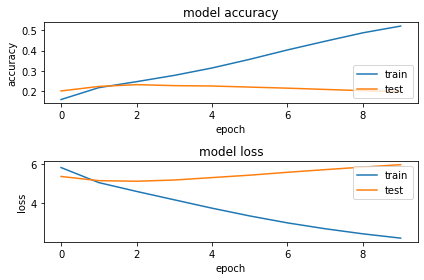

In [30]:
# Plot train and validation curves
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()